## ResNet Model Training Code

In [26]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(0)}") # For the first GPU
else:
    print("GPU is not available.")

GPU is available.
Number of GPUs: 1
Current GPU name: NVIDIA RTX A5500 Laptop GPU


In [27]:
import torch
import pandas as pd
import torchvision
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt


## Sample Image from Dataset

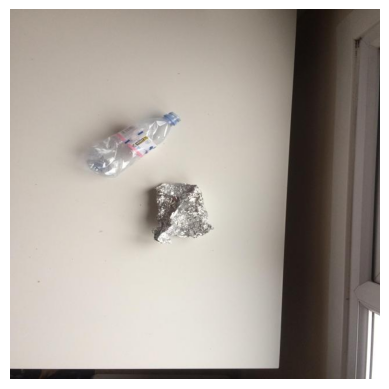

In [28]:
dataset_path = "split/train/images"

sample_img = os.path.join(dataset_path, "6.jpg")
img = cv2.imread(sample_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()


In [29]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from PIL import Image
from tqdm import tqdm


class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + ".txt")

        img = Image.open(img_path).convert("RGB")
        img_w, img_h = img.size

        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x, y, w, h = map(float, line.strip().split())
                    x_min = (x - w / 2) * img_w
                    y_min = (y - h / 2) * img_h
                    x_max = (x + w / 2) * img_w
                    y_max = (y + h / 2) * img_h
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(int(cls) + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target, img_name



In [ ]:
# -------------------- IoU function --------------------
def box_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    xB = min(boxA[2], boxB[2])
    yA = max(boxA[1], boxB[1])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    if inter == 0:
        return 0.0
        
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return inter / float(boxA_area + boxB_area - inter)


HYPERPARAMS = {
    "lr": [5e-3, 1e-3, 5e-4, 1e-4],
    "batch_size": [8],
    "image_size": [320, 480, 640],
    "weight_decay": [0, 1e-4, 5e-4],
    "optimizer": ["adam", "sgd"]

}

NUM_CLASSES = 4
MAX_EPOCHS = 3                 # QUICK tuning (not full training)
ACC_IOU_THRESHOLD = 0.6


## Loading Pre-trained model

In [35]:
def build_retinanet(num_classes=4, lr=1e-3, optimizer_type="adam"):
    model = retinanet_resnet50_fpn_v2(weights="DEFAULT")

    in_channels = model.backbone.out_channels
    num_anchors = model.head.classification_head.num_anchors

    # Replace classification head for your classes
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if optimizer_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    return model, optimizer


In [36]:
def get_loader(img_size, batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    dataset = YOLODataset("split/train/images", "split/train/labels", transforms=transform)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )
    
    return loader


In [44]:
results = []

param_combinations = itertools.product(
    HYPERPARAMS["lr"],
    HYPERPARAMS["batch_size"],
    HYPERPARAMS["image_size"],
    HYPERPARAMS["optimizer"]
)

for lr, batch_size, img_size, opt_name in param_combinations:
    print(f"\n⚡ Testing LR={lr}, BS={batch_size}, IMG={img_size}, OPT={opt_name}")

    loader = get_loader(img_size, batch_size)

    model, optimizer = build_retinanet(
        num_classes=NUM_CLASSES, lr=lr, optimizer_type=opt_name
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ----- Quick 2-epoch Training -----
    model.train()
    epoch_losses = []
    epoch_accs = []

    for epoch in range(MAX_EPOCHS):
        total_loss = 0
        all_gt = []
        all_pred = []

        loop = tqdm(loader, desc=f" Epoch {epoch+1}/{MAX_EPOCHS}")

        for images, targets, _ in loop:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

            # ========== QUICK ACC ESTIMATION ==========
            model.eval()
            preds = model(images)
            model.train()

            for pred, tgt in zip(preds, targets):
                pred_boxes = pred["boxes"].detach().cpu().numpy()
                pred_labels = pred["labels"].detach().cpu().numpy()

                gt_boxes = tgt["boxes"].detach().cpu().numpy()
                gt_labels = tgt["labels"].detach().cpu().numpy()

                for p_box, p_label in zip(pred_boxes, pred_labels):
                    best_iou = 0
                    best_gt_label = None
                    for g_box, g_label in zip(gt_boxes, gt_labels):
                        iou = box_iou(p_box, g_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_label = g_label

                    if best_iou >= ACC_IOU_THRESHOLD:
                        all_gt.append(best_gt_label)
                        all_pred.append(p_label)

        avg_loss = total_loss / len(loader)
        acc = (np.array(all_gt) == np.array(all_pred)).mean() if len(all_gt) > 0 else 0

        epoch_losses.append(avg_loss)
        epoch_accs.append(acc)

    # Store the result
    results.append({
        "lr": lr,
        "batch_size": batch_size,
        "image_size": img_size,
        "optimizer": opt_name,
        "loss": np.mean(epoch_losses),
        "accuracy": np.mean(epoch_accs)
    })



⚡ Testing LR=0.005, BS=8, IMG=320, OPT=adam


 Epoch 1/3:  13%|█▎        | 93/742 [29:17<3:24:28, 18.90s/it]


KeyboardInterrupt: 

In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="accuracy", ascending=False)

print("\n🎯 Hyperparameter Tuning Results:")
df_results


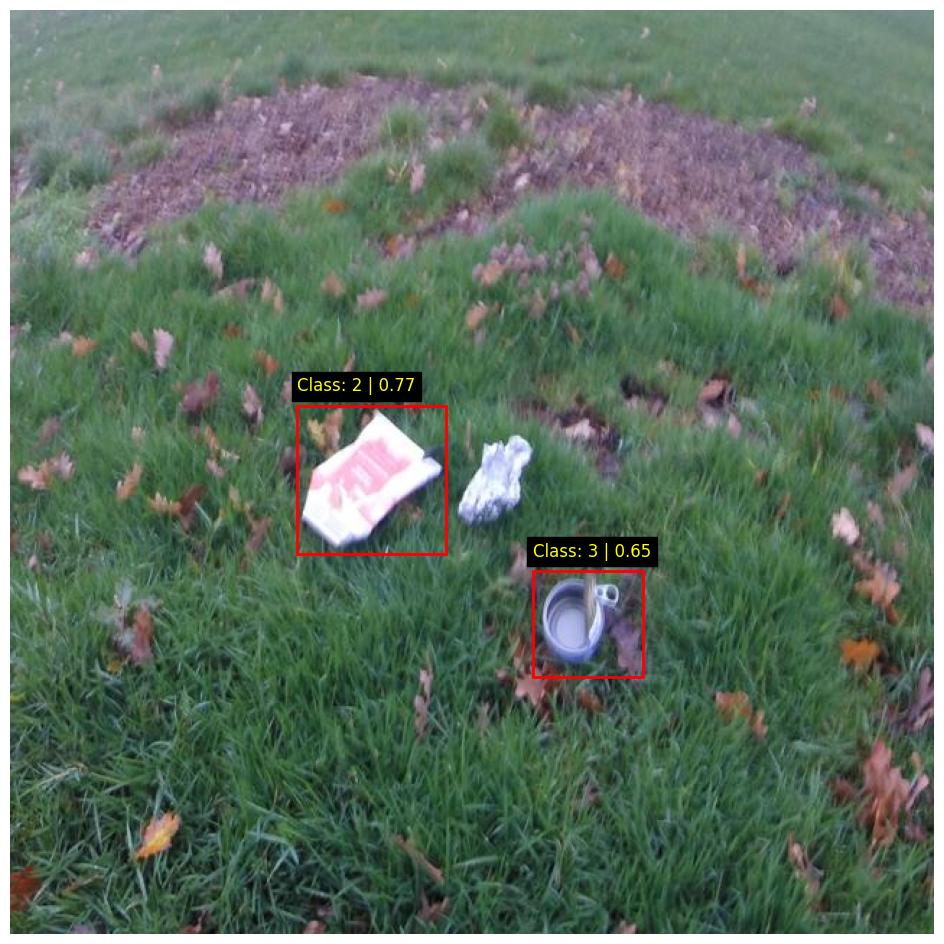

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_predictions(image_path, boxes, labels, scores, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold:
            continue
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(x_min, y_min - 10, f'Class: {label.item()} | {score:.2f}', color='yellow', fontsize=12, backgroundcolor="black")

    plt.axis('off')
    plt.show()

visualize_predictions(image_path, boxes, labels, scores)
